# Example of usage Spark OCR for de-identify Dicom documents using ImageToTextV2

## Install spark-ocr python packge
Need specify:
- license
- path to `spark-ocr-assembly-[version].jar` and `spark-nlp-jsl-[version]`
- or `secret` for Spark OCR and `nlp_secret` for Spark NLP Internal
- `aws_access_key` and `aws_secret_key`for download pretrained models

For more details about Dicom de-identification please read:

 - [DICOM de-identification at scale in Visual NLP — Part 1.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-1-68784177f5f0)

 - [DICOM de-identification at scale in Visual NLP — Part 2.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-2-361af5e36412)

 - [DICOM de-identification at scale in Visual NLP — Part 3.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-3-61cecc3adb56)

In [1]:
license = ""
secret = ""
nlp_secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12"

## Initialization of spark session

In [2]:
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key


spark = start(secret=secret,
              nlp_secret=nlp_secret,
              jar_path=spark_ocr_jar_path,
              nlp_internal="5.4.1")

spark

Spark version: 3.2.1
Spark NLP version: 5.4.1
Spark NLP for Healthcare version: 5.4.1
Spark OCR version: 5.4.2rc2



## Import Spark OCR transformers and Spark NLP annotators

In [3]:
import os
import sys

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *

from pyspark.ml import PipelineModel, Pipeline

print(f"Spark NLP version: {sparknlp.version()}")
print(f"Spark NLP internal version: {sparknlp_jsl.version()}")
print(f"Spark OCR version: {sparkocr.version()}")

Spark NLP version: 5.4.1
Spark NLP internal version: 5.4.1
Spark OCR version: 5.4.2rc2


## Define de-identification  NLP pipeline

In [4]:
def deidentification_nlp_pipeline(input_column, prefix = "", model="ner_deid_large"):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document_raw")

    cleanUpPatterns = ["<[^>]>"]
    documentNormalizer = DocumentNormalizer() \
      .setInputCols(prefix + "document_raw") \
      .setOutputCol(prefix + "document") \
      .setAction("clean") \
      .setPatterns(cleanUpPatterns) \
      .setReplacement(" ") \
      .setPolicy("pretty_all")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")

    clinical_ner = MedicalNerModel.pretrained(model, "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT',
                   'LOCATION', 'PROFESSION', 'PERSON', 'DATE', 'DOCTOR'])

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            documentNormalizer,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

## Define OCR transformers and pipeline for image deidentification

In [18]:
from pyspark.ml import PipelineModel, Pipeline

dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(True)

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setWithRefiner(False) \
    .setLinkThreshold(0.3)

ocr = ImageToTextV2.pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
    .setRegionsColumn("text_regions") \
    .setInputCols(["image_raw"]) \
    .setOutputCol("text") \
    .setOutputFormat("text_with_positions") \
    .setGroupImages(False)

# Found coordinates of sensitive data
position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setOcrScaleFactor(1.0)

# Draw filled rectangle for hide sensitive data
draw_regions = DicomDrawRegions() \
    .setInputCol("content") \
    .setInputRegionsCol("coordinates") \
    .setOutputCol("dicom") \
    .setAggCols(["path", "content"]) \
    .setKeepInput(True)

dicom_deidentifier = DicomMetadataDeidentifier() \
    .setInputCols(["dicom"]) \
    .setOutputCol("dicom_cleaned")\
    .setKeepInput(True)

# OCR pipeline
pipeline = PipelineModel(stages=[
    dicom_to_image,
    text_detector,
    ocr,
    deidentification_nlp_pipeline(input_column="text", prefix="", model="ner_deid_generic_augmented"),
    position_finder,
    draw_regions,
    dicom_deidentifier
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_generic_augmented download started this may take some time.
[OK!]


## Read dicom objects as binary file and display metadata

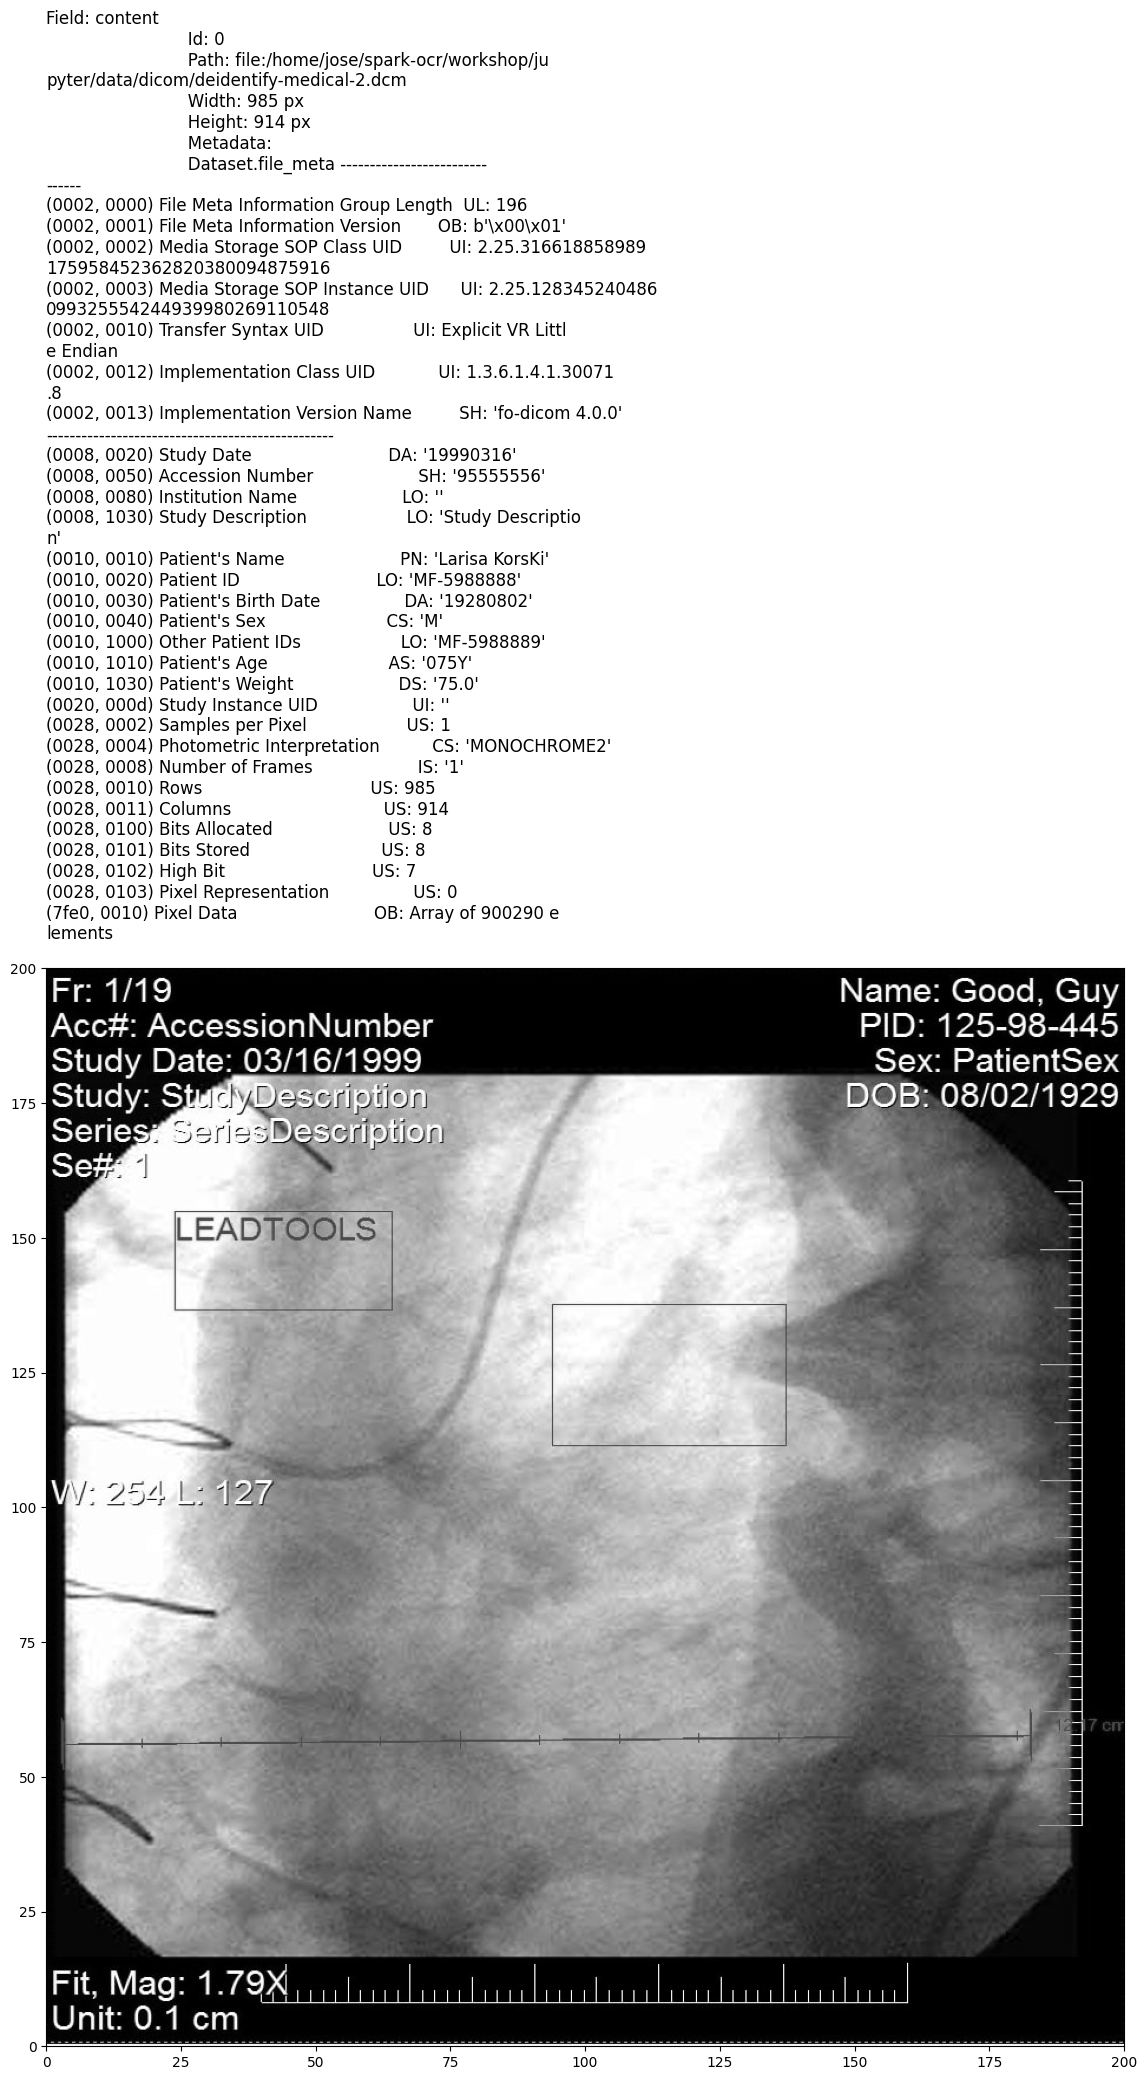

In [22]:
dicom_path = './../data/dicom/*.dcm'
dicom_df = spark.read.format("binaryFile").load(dicom_path).limit(1)

display_dicom(dicom_df)

In [19]:
result = pipeline.transform(dicom_df).cache()

## Inspect Intermmediate Stages

In [13]:
import pandas as pd
pd.set_option('display.max_colwidth', 500)
result.select("exception", "text", "text_regions", "ner", "coordinates").toPandas()

,exception,text,text_regions,ner,coordinates
0,,"FR 1/19 NAME: GOOD GUY\nACC#: ACCESSIONNUMBER PID: 125-98-445\nSTUDY DATE: 03/16/1999 SEX: PATIENTSEX\nSTUDY: STUDYDESCRIPTION DOB: 08/02/1929\nSERIES: SERIESDESCRIPTION\nSE#:\nLEADTOOLS\nW: 254 L: 127\n17 CM\nFIT, MAG: 1.79X\nUNIT: 0.1 CM","[(0, 0, 22.31640625, 20.0078125, 38.4765625, 27.703125, 0.0, , 0.0, True), (0, 0, 78.4921875, 20.0078125, 61.5625, 27.703125, 0.0, , 0.0, True), (0, 0, 716.43359375, 20.77734375, 87.7265625, 26.1640625, 0.0, , 0.0, True), (0, 0, 803.390625, 20.777339935302734, 73.875, 26.16405487060547, 0.0, , 0.0, True), (0, 0, 882.4839477539062, 22.19915199279785, 58.659515380859375, 28.377056121826172, 0.0, , 7.765167713165283, True), (0, 0, 41.5546875, 53.09765625, 73.875, 26.1640625, 0.0, , 0.0, True), ...","[(named_entity, 0, 1, O, {'sentence': '0', 'word': 'FR', 'confidence': '0.9999'}, []), (named_entity, 3, 6, B-DATE, {'sentence': '0', 'word': '1/19', 'confidence': '0.9998'}, []), (named_entity, 8, 11, O, {'sentence': '0', 'word': 'NAME', 'confidence': '1.0'}, []), (named_entity, 12, 12, O, {'sentence': '0', 'word': ':', 'confidence': '0.9997'}, []), (named_entity, 14, 17, B-NAME, {'sentence': '0', 'word': 'GOOD', 'confidence': '0.6962'}, []), (named_entity, 19, 21, I-NAME, {'sentence': '0',...","[(0, 0, 47.7109375, 6.15625, 61.5625, 27.703125, 0.0, 0, 0.0, False), (1, 0, 766.453125, 7.830445766448975, 144.7408447265625, 27.112485885620117, 0.0, 0, 0.0, False), (2, 0, 84.6484375, 36.9375, 246.24996948242188, 29.2421875, 0.0, 0, 0.0, False), (3, 0, 175.45816040039062, 69.25780487060547, 144.20712280273438, 30.0848388671875, 0.0, 0, 0.0, False), (4, 0, 755.1666870117188, 101.578125, 155.95831298828125, 27.703125, 0.0, 0, 0.0, False), (5, 0, 104.65623474121094, 135.43748474121094, 233.9..."


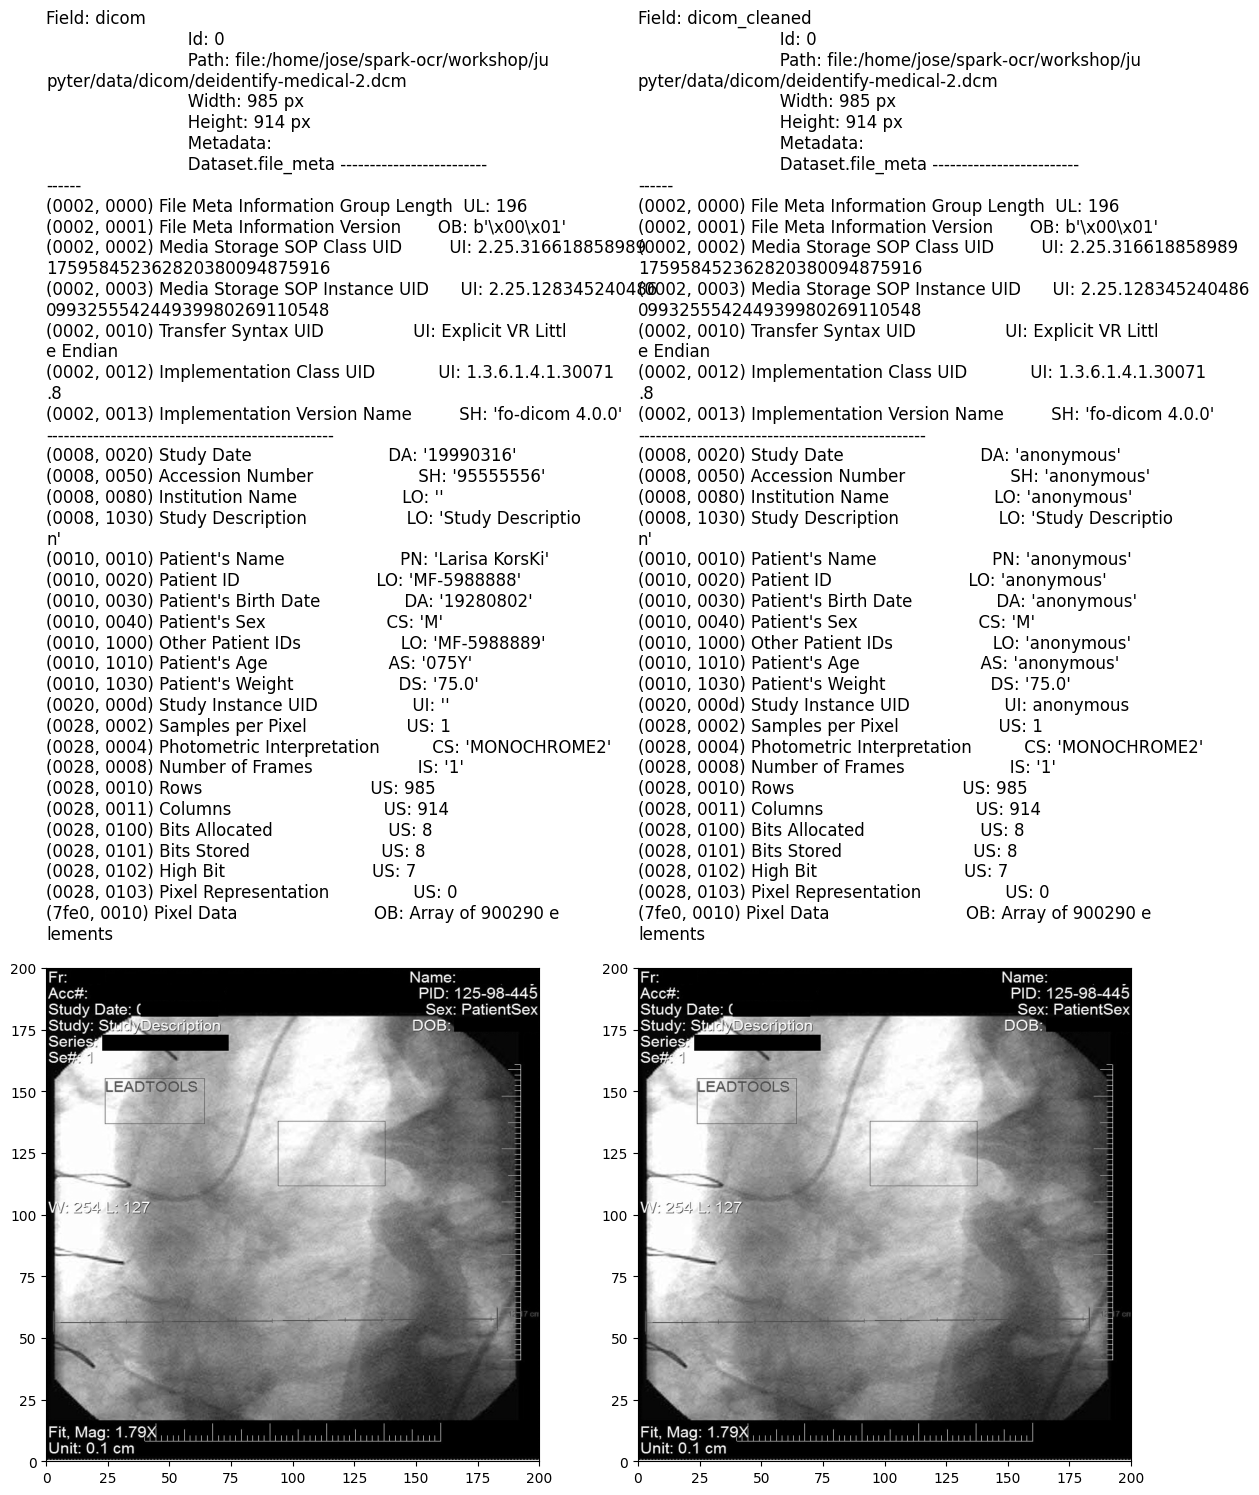

In [21]:
display_dicom(result, "dicom, dicom_cleaned")

## Write results back to disk

In [23]:
# NBVAL_SKIP
output_path = "./../data/dicom/deidentified/"
from pyspark.sql.functions import *

def get_name(path, keep_subfolder_level=0):
    path = path.split("/")
    path[-1] = path[-1].split('.')[0]
    return "/".join(path[-keep_subfolder_level-1:])

result.withColumn("fileName", udf(get_name, StringType())(col("path"))) \
    .write \
    .format("binaryFormat") \
    .option("type", "dicom") \
    .option("field", "dicom_cleaned") \
    .option("prefix", "ocr_") \
    .option("nameField", "fileName") \
    .mode("overwrite") \
    .save(output_path)

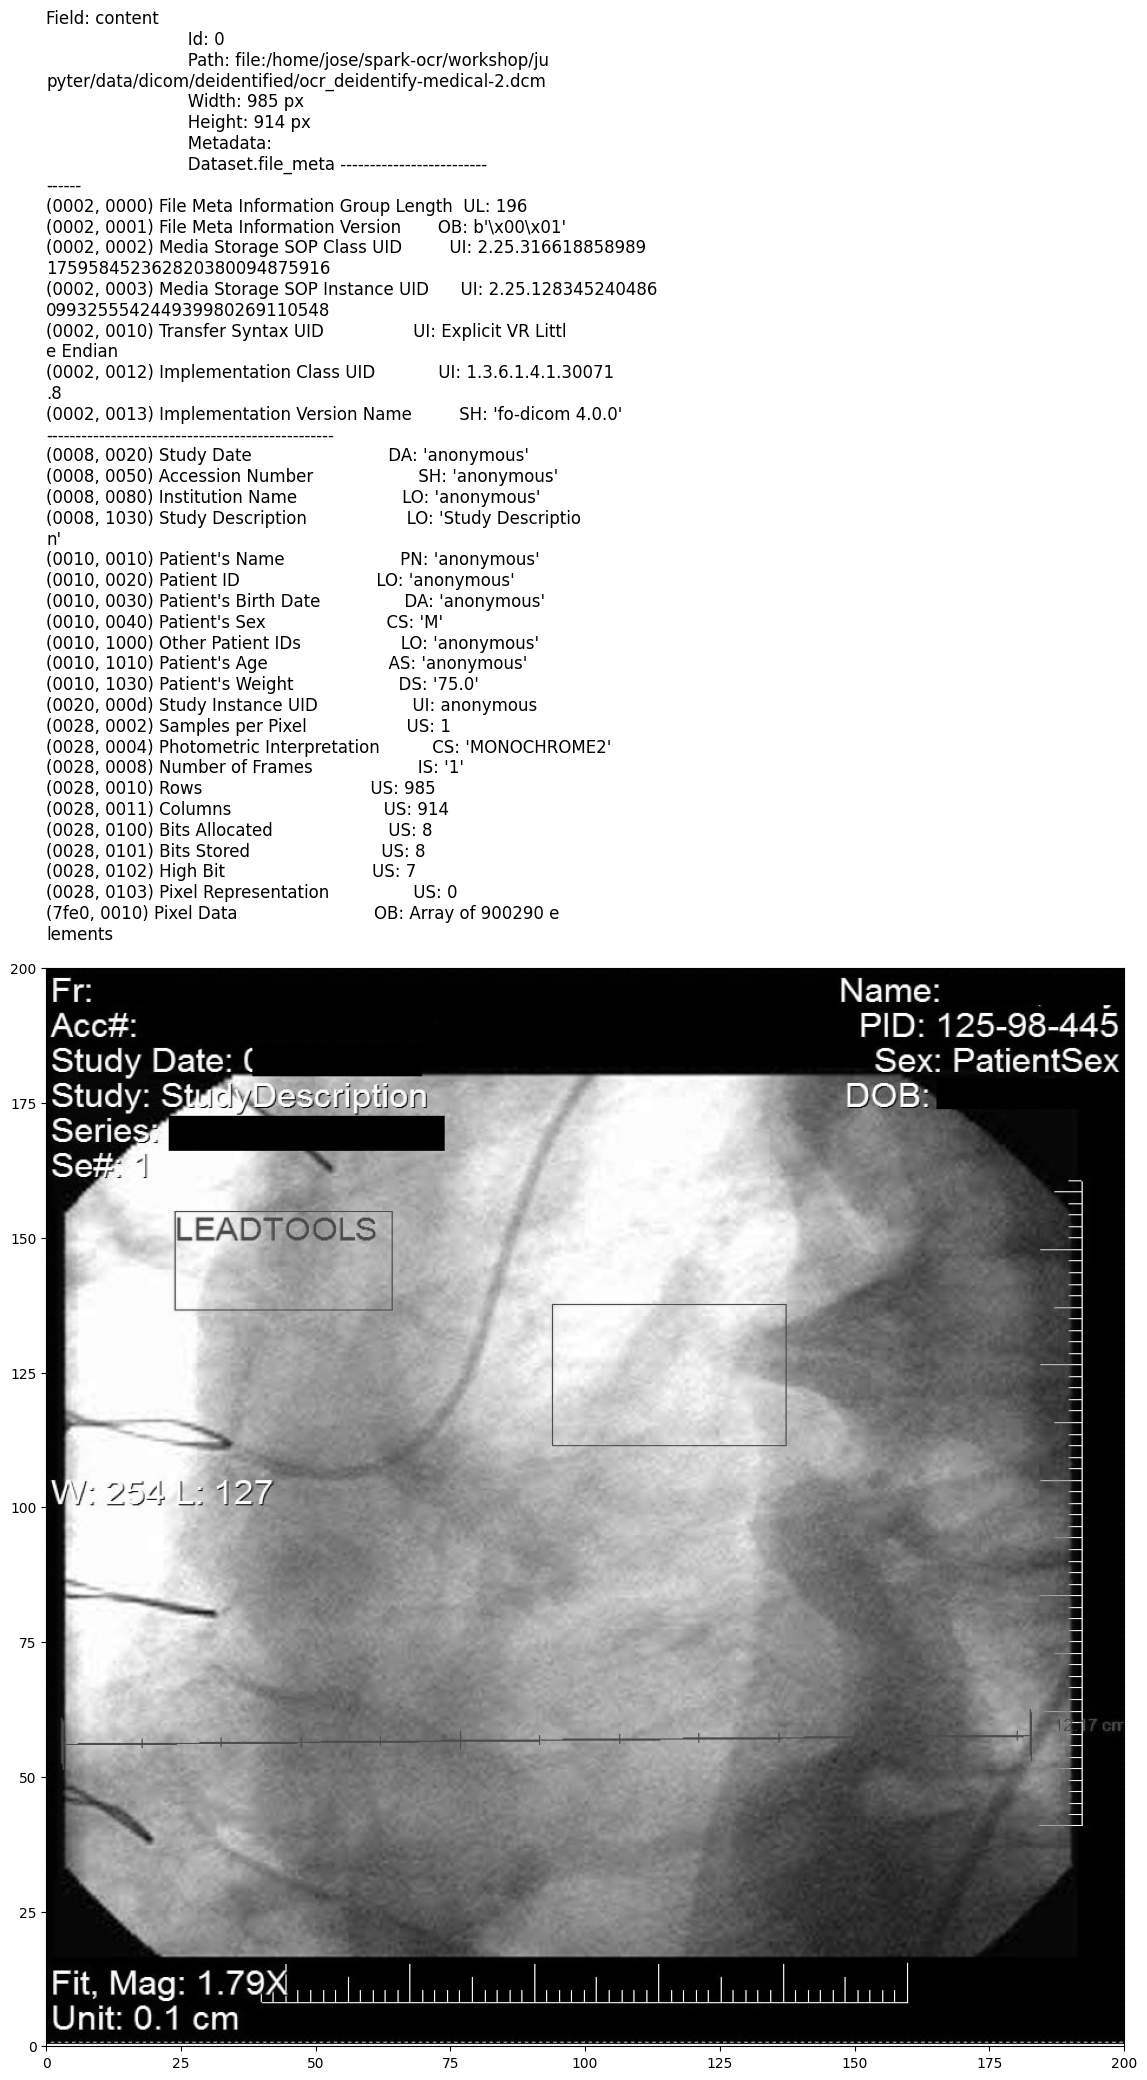

In [24]:
# NBVAL_SKIP
dicom_gen_df = spark.read.format("binaryFile").load("./../data/dicom/deidentified/*.dcm")
display_dicom(dicom_gen_df)

In [33]:
%%bash
rm -r -f ./../data/dicom/deidentified